In [2]:
#!/usr/bin/env python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import json
import uuid as uuid
import cv2
import re
import shutil
from operator import itemgetter
import math
import random
import seaborn as sns

import shapely
import shapely.geometry
from shapely.geometry import Polygon,MultiPolygon,GeometryCollection
from shapely.validation import make_valid
from shapely.geometry import mapping
import geopandas as gpd


In [3]:
# main code BLOCK 1
## listing directory structure
projdir='/Users/lovely_shufan/Dropbox (Edison_Lab@UGA)/UGA PhD/image analysis/REU_2023_Arline/workdir/01_tiling/'   #working directory
img_dir=projdir+'raw_images_annotations/' #input: image directory
output_dir=projdir+'ouput/'           #output: tiled image directory
preproc_dir=projdir+'preprocess/'      #intermediate: 
data_sep_dir=projdir+'datasep/'        #intermediate:
qc_dir=projdir+'qc/'                   #intermediate: quality check

## making directories 
os.makedirs(output_dir,exist_ok=True)
os.makedirs(preproc_dir,exist_ok=True)
os.makedirs(data_sep_dir,exist_ok=True)
os.makedirs(qc_dir,exist_ok=True)

In [5]:
def readAnnotation(img_dir):
    '''
    :param img_dir: image folder
    :return list of dictionaries: annotation table and file list
    '''
    anno_file=os.path.join(img_dir,"TrainingSet003_Arline_annotation_via_project_20July23_12.28pm_csv.csv")
    annotab=pd.read_csv(anno_file,delimiter=",")
    files=annotab['filename'].unique()
    return annotab, files

def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')
    
def noHolePolygon(polygon):
    # convert new annotations from polygons to points
    exterior = list(polygon.exterior.coords)[:-1] #remove the last point which is the same as the first point
    interior = list(polygon.interiors)
                
    if interior != []:
        # merge interior point/linearring with exterior points
        interior = GeometryCollection(interior)
        for geom in interior.geoms: 
            for i in mapping(geom)['coordinates'][:-1]:
                exterior.append(i)
    return exterior

In [16]:
## changed working directory to output_dir
os.chdir(output_dir) 

## read in annotation csv file and image file names
annotab,files=readAnnotation(img_dir)
#print(annotab.shape)

## preprocess the annotation table
classes=['AMF arbuscule island','AMF arbsucule forest ']

### drop template images
exclude_file = ['Snap-12327-Image Export-127.jpg', 'Snap-12291-Image Export-91.jpg','Snap-12220-Image Export-20.jpg']
annotab = annotab[~annotab['filename'].isin(exclude_file)]
#print(annotab['filename'].unique())
#print(annotab['region_attributes'].unique())
#print(annotab.shape)

### remove unnecessary annotations based on class
exclude_anno = ['{"object":"AMF internal hypha"}', '{}']
annotab = annotab[~annotab['region_attributes'].isin(exclude_anno)]
#print(annotab.shape)
#print(annotab['region_attributes'].unique())

rem = annotab['region_attributes'].unique()
files = annotab['filename'].unique()


    
# convert multipolygon to polygons by removing LinearRing
#anno_list = []
#poly_type = []
#for i in range(0, annotab.shape[0],1):
#    anno = json.loads(annotab.iloc[i]['region_shape_attributes'])
#    anno_points = convertPoints(anno)
#    anno_polygon = Polygon(anno_points)
#    anno_polygon = make_valid(anno_polygon)
#    
#    #poly_type.append(anno_polygon.geom_type)
#    if anno_polygon.geom_type == "MultiPolygon":
#        # keep the largest polygon
#        poly_area = []
#        for geom in anno_polygon.geoms:
#            poly_area.append(geom.area)
#        new_anno = anno_polygon.geoms[poly_area.index(max(poly_area))]
#        # note that the points in noHolePolygon may not be sorted
#        new_anno = noHolePolygon(new_anno)
#        anno_list.append(new_anno)
#    else:
#        if anno_polygon.geom_type == "GeometryCollection":
#            # remove linestring
#            for geom in anno_polygon.geoms:
#                if geom.geom_type == 'Point' or geom.geom_type == 'LineString':
#                    continue
#                else:
#                    # note that the points in noHolePolygon may not be sorted
#                    new_anno = noHolePolygon(geom)
#                    anno_list.append(new_anno)
#        else: #is polygon
#            new_anno = noHolePolygon(anno_polygon)
#            anno_list.append(new_anno)

    
    
# save a copy of preprocessed annotation data
#for file_name in files:
    #shutil.copy(img_dir+file_name,preproc_dir+file_name) # moving images from img_dir to preproc dir    
    
    
annotab.to_csv(preproc_dir+'TrainingSet003_Arline_annotation_via_project_20July23_12.28pm_csv_preprocessed.csv',index=False) # saving a copy of cleaned annotation csv to preproc folder



In [17]:
def readImage(img_dir,filename):
    '''
    :param img_dir:
    :param filename:
    :return image:
    '''
    img_file=os.path.join(img_dir,filename)
    img=cv2.imread(img_file)
    height = img.shape[0]
    width = img.shape[1]
    # pad image to optimal input image dimension of [800, 1333]
    # padding to the left and the bottom of the image as it was mostly empty
    pad_bot = height % 800 
    pad_lft = width % 1333
    # pad the image
    img = cv2.copyMakeBorder(img,0,pad_bot,pad_lft,0,cv2.BORDER_CONSTANT,value=[0,0,0])
    return img

In [18]:
def tileImage(img):
    '''
    :param img:
    :return list of coordinates:
    :rtype list:
    Objective: output a list of coordinates for the bounding boxes of the tiles
    '''
    tiles = [] # an empty list 
    for i in range(0,img.shape[0],800):
        for j in range(0,img.shape[1],1333):
            #print(i, " ", j)
            #tile = [[j, i],[j, i+800], [j+1333, i], [j+1333, i+800]]
            xmin = j
            xmax = j + 1333
            ymin = i
            ymax = i + 800
            tiles.append([xmin,ymin,xmax,ymax])
    #print(tiles)
    return tiles

In [19]:

sub = annotab[annotab['region_attributes']=='{"object":"AMF arbuscule island"}']
island_size=[]
sub2 = annotab[annotab['region_attributes']=='{"object":"AMF arbsucule forest "}']
forest_size=[]
for i in range(0,sub.shape[0],1): #iterate over each annotation
    anno = json.loads(annotab.iloc[i]['region_shape_attributes'])
    anno_points = convertPoints(anno)
    anno_polygon = Polygon(anno_points)
    anno_polygon = make_valid(anno_polygon)
    island_size.append(anno_polygon.area)

for i in range(0,sub2.shape[0],1): #iterate over each annotation
    anno = json.loads(annotab.iloc[i]['region_shape_attributes'])
    anno_points = convertPoints(anno)
    anno_polygon = Polygon(anno_points)
    anno_polygon = make_valid(anno_polygon)
    forest_size.append(anno_polygon.area)

CNN2_Keyence_Nbenth_myc_8.jpg
[0, 0, 1333, 800]
[1333, 0, 2666, 800]
[2666, 0, 3999, 800]
[3999, 0, 5332, 800]
[5332, 0, 6665, 800]
[6665, 0, 7998, 800]
[7998, 0, 9331, 800]
[9331, 0, 10664, 800]
[0, 800, 1333, 1600]
[1333, 800, 2666, 1600]
[2666, 800, 3999, 1600]
[3999, 800, 5332, 1600]
multipolygon


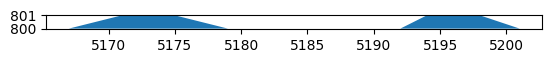

MULTIPOLYGON (((5171 801, 5175 801, 5179 800, 5167 800, 5171 801)), ((5194 801, 5198 801, 5201 800, 5192 800, 5194 801)))


TypeError: unsupported operand type(s) for -: 'tuple' and 'int'

In [25]:
anno_size = []
intersect_size = []
for indi,image_name in enumerate(files): #iterate over each image
    print(image_name)
    img = readImage(img_dir,image_name)
    tiles = tileImage(img)
    
    img_annotab = annotab[annotab['filename'] == image_name]
    for tile in tiles: #iterate over each tile in an image
        print(tile)
        xmin = tile[0]
        ymin = tile[1]
        xmax = tile[2]
        ymax = tile[3]
        tilebox = Polygon([(xmin,ymin),(xmax,ymin),(xmax,ymax),(xmin,ymax)])
        for i in range(0,img_annotab.shape[0],1): #iterate over each annotation
            intersect_point_list = []
            
            loadcldict = json.loads(img_annotab.iloc[i]['region_attributes'])
            category_id = classes.index(loadcldict['object'])
            #print(loadcldict['object'])
            #print(category_id)
            
            anno = json.loads(img_annotab.iloc[i]['region_shape_attributes'])
            anno_points = convertPoints(anno)
            anno_polygon = Polygon(anno_points)
            anno_polygon = make_valid(anno_polygon)
            intersect_polygon = anno_polygon.intersection(tilebox)
            
            is_empty = intersect_polygon.is_empty
            is_point = intersect_polygon.geom_type=='Point'
            is_line = intersect_polygon.geom_type=='LineString'
            is_polygon = intersect_polygon.geom_type=='Polygon'
            is_polygon_multi = intersect_polygon.geom_type=='MultiPolygon'
            is_mutliothers = intersect_polygon.geom_type=='GeometryCollection'
            
            anno_size.append(anno_polygon.area)
            if is_empty or is_point or is_line:
                continue

            else:  
                intersect_size.append(intersect_polygon.area)
                if is_polygon_multi:
                    print("multipolygon")
                    polyplot = gpd.GeoSeries([intersect_polygon])
                    polyplot.plot()
                    plt.show()
                    print(intersect_polygon)
                    
                    for geom in intersect_polygon.geoms:
                        intersect_point_list.append(noHolePolygon(geom))
                        #print(geom.geom_type)
                        #print(noHolePolygon(geom))
                else:
                    if is_mutliothers:
                        #print("GeometryCollection")
                        #polyplot = gpd.GeoSeries([intersect_polygon])
                        #polyplot.plot()
                        #plt.show()
                        #print(intersect_polygon)
                        for geom in intersect_polygon.geoms:
                            #print(geom.geom_type)
                            if geom.geom_type == 'Point' or geom.geom_type == 'LineString':
                                continue #skip the rest of the code in the loop
                            intersect_point_list = noHolePolygon(geom)
                    else:
                        #print("Polygon")
                        #polyplot = gpd.GeoSeries([intersect_polygon])
                        #polyplot.plot()
                        #plt.show()
                        intersect_point_list = noHolePolygon(intersect_polygon)
                        
            # transform point to tile coordinates
            transformed_point_list = transformPoints(intersect_point_list, xmin, ymin)
            
            # find bounding box of annotation
            Sxmin=min(transformed_point_list,key=lambda x:x[0])[0]
            #print(Sxmin)
            Symin=min(transformed_point_list,key=lambda x:x[1])[1]
            Sxmax=max(transformed_point_list,key=lambda x:x[0])[0]
            Symax=max(transformed_point_list,key=lambda x:x[1])[1]  
            Segbbox = [Sxmin,Symin,Sxmax,Symax]
            
            # reformat point list from [[x,y],[x,y]...] to [x,y,x,y,x,y,....]
            #print(transformed_point_list)
            transformed_point_list=[item for sublist in transformed_point_list for item in sublist]
            #print(transformed_point_list)
            
#             # group all info
#             obj = {
#                 'filename': tile_id + '.jpg',
#                 "image_id": tile_id,
#                 'structure_id': uid,
#                 'height': 512,
#                 'width': 512,
#                 "category_id": className,
#                 "bbox": Segbbox,
#                 "segmentation": converted_points,
#                 "bbox_mode": 'BoxMode.XYXY_ABS',
#                 "iscrowd":0,
#                 }
                #record["annotations"].append(obj)

In [22]:
print(np.mean(anno_size))
print(max(anno_size))
sns.displot(anno_size,binwidth=500)
sns.displot(island_size,binwidth=500)
sns.displot(forest_size,binwidth=500)

nan


/Users/lovely_shufan/opt/anaconda3/envs/shapely/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/lovely_shufan/opt/anaconda3/envs/shapely/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: max() arg is an empty sequence

In [14]:
def convertPoints(anno):
    '''
    :param anno:
    :paramtype list:
    :param img:
    :paramtype numpy array:
    :param annotab:
    :paramtype pandas dataframe:
    :param files:
    :paramtype list:
    :param classes:
    :paramtype list:
    :return dataset_dicts:
    :rtype list:
    Objective: iterate over each of the segmentations in the image and intersect them with the tile bounding boxes
    '''
    points = []
                    
    for x_coordinate in range(0,len(anno["all_points_x"]),1):
        points.append([anno["all_points_x"][x_coordinate],anno["all_points_y"][x_coordinate]])
    
    # remove empyt lists from the list of points
    points = [x for x in points if x]
    return points

def transformPoints(points,xmin,ymin):
    transformed_points = []
    for point in points:
        #print(p)
        p2 = []
        #print(type(p2[0]))
        p2.append(point[0]-xmin)
        p2.append(point[1]-ymin)
        transformed_points.append(p2)
    #print(transformed_points)
    return transformed_points

def findBoundingBox(points):
    '''
    :param points:
    :paramtype list:  points forming one annotation converted to pair format, i.e. [[x,y],[x,y]...]
    Objective: find the bounding box of an annotation
    '''   
    Sxmin=min(points,key=lambda x:x[0])[0]
    Symin=min(points,key=lambda x:x[1])[1]
    Sxmax=max(points,key=lambda x:x[0])[0]
    Symax=max(points,key=lambda x:x[1])[1]
    Segbbox = [Sxmin,Symin,Sxmax,Symax]
    return Segbbox

def intersectmask(anno,xmin, ymin, xmax, ymax):
    '''
    :param points:
    :paramtype list: points forming one annotation converted to pair format, i.e. [[x,y],[x,y]...]
    :param xmin:
    :paramtype int:  left x coordinate of a tile 
    :param xmax:
    :paramtype int:  right x coordinate of a tile 
    :param ymin:
    :paramtype int:  upper y coordinate of a tile 
    :param ymax:
    :paramtype int:  bottom y coordinate of a tile 
    Objective: iterate over each of the segmentations in the image and intersect them with the tile bounding boxes
    '''    
    intersect_point_list=[]
    
    # create shapely object for each tile and annotation
    tilebox = Polygon([(xmin,ymin),(xmax,ymin),(xmax,ymax),(xmin,ymax)])
    points = convertPoints(anno) # convert coordinates to points in [x,y] format
    polygon_anno = Polygon(points)
    polygon_anno = make_valid(polygon_anno) # all annotation should be valid after the make_valid
    # it is ok for an annotation to be multipolygon and geometryCollection
    
    # create intersection between tile box and annotation
    intersect_anno = polygon_anno.intersection(tilebox)
    
    # converting polygon_inters from shapely object to list of points
    if (not intersect_anno.is_empty): #empty intersections are dropped
        is_polygon = intersect_anno.geom_type=='Polygon'
        is_polygon_multi = intersect_anno.geom_type=='MultiPolygon'
        is_mutliothers = intersect_anno.geom_type=='GeometryCollection'
        
        if is_polygon or is_multipolygon or is_mutliothers: # points and lines are dropped
            # layout three possible object types of intersected annotation
            if is_polygon: 
                intersect_point_list = noHolePolygon(intersect_anno)
            else: # finished one object type, two more to go
                if is_multipolygon: 
                    # merge elements in a multipolygon to one
                    for geom in intersect_anno.geoms:
                        intersect_point_list.append(noHolePolygon(geom))
                    
                else: #is GeometryCollection
                    for geom in intersect_anno.geoms:
                        if geom.geom_type == 'Point' or geom.geom_type == 'LineString':
                            continue #skip the rest of the code in the loop
                        intersect_point_list = noHolePolygon(geom)
    
        # transform point to using tile coordinates      
        transformed_point_list = transformPoints(intersect_point_list, xmin, ymin)
    else:
        transformed_point_list = []
        
    # reformat point list from [[x,y],[x,y]...] to [x,y,x,y,x,y,....]
    transformed_point_list=[element for point in transformed_point_list for element in point]
    
    return transformed_point_list

def IntersectSegmentations(img_dir,output_dir,tiles,img,annotab,file,classes):
    '''
    :param tiles:
    :paramtype list:
    :param img:
    :paramtype numpy array:
    :param annotab:
    :paramtype pandas dataframe:
    :param files:
    :paramtype list:
    :return records:
    :rtype list:
    Objective: iterate over each of the segmentations in the image and intersect them with the tile 
    '''
    
    filename=os.path.join(img_dir,file)
    
    # iterate over the tiles in an image
    records=[] # a record contains all annotations in a tile, records contain all tiles in an image
    for ind,tile in enumerate(tiles):
        record = {}
        record["filename"] = tile_id + '.jpg'
        record["height"] = 800
        record["width"] = 1333
        record["annotations"] = []
        
        xmin=tile[0]
        ymin=tile[1]
        xmax=tile[2]
        ymax=tile[3]
        # make a tile id using the xmin,ymin,xmax,ymax and the filename
        tile_id = file[:-4] + '_'+ str(xmin)+"_"+str(ymin)+"_"+str(xmax)+"_"+str(ymax)
        
        #iterate over each annotation to find the ones intersecting the tile
        subtab = annotab[annotab['filename'] == file]
        for i in range(0,subtab.shape[0],1): 
            tab_rec = subtab.iloc[i]
            # get annotation coordinates
            anno = json.loads(tab_rec["region_shape_attributes"]) 
            
            # find intersection between an annotation and tiles
            intersect_point_list = intersectmask(anno,xmin,ymin,xmax,ymax)
            
            # check whether intersection is empty
            if len(intersect_point_list) == 0:
                continue
            else:
                
                # get its bounding box
                Segbbox = findBoundingBox(intersect_point_list)
                
                # make a UID for non-empty intersect
                uid = str(uuid.uuid4())
                
                # get annotation label 
                # input for mask rcnn require category_id to be int in the range of in the range [0, num_categories-1]
                loadcldict = json.loads(tab_rec['region_attributes'])
                category_id = classes.index(loadcldict['object'])
                
                obj = {
                    'filename': tile_id + '.jpg',
                    'image_id': tile_id,
                    'structure_id': uid,
                    'height': 800,
                    'width': 1333,
                    'category_id': category_id,
                    'bbox': Segbbox,
                    'segmentation': intersect_point_list,
                    'bbox_mode': 'BoxMode.XYXY_ABS',
                    'iscrowd':0
                    }
                
                record["annotations"].append(obj)
                
        if len(record['annotations']) > 0:
            #subset the image to the tile coordinates
            subimg=img[ymin:ymax,xmin:xmax]
            # write the tile image to the output directory
            cv2.imwrite(os.path.join(output_dir,tile_id+'.jpg'),subimg)
            records.append(record)
    
    return records

#def writeSegmentationCSV(dictionary):
    

In [35]:
# main code BLOCK 2 
## tiling
dataset_dicts=[] # a list of records (list of dictionaries named record)
for indi,original_image in enumerate(files): #iterate over each image
    print(stained_image)
    img = readImage(img_dir,stained_image)
    tiles = tileImage(img)
    records = IntersectSegmentations(img_dir,output_dir,tiles,img,annotab,original_image)
    dataset_dicts.extend(records) 

CNN2_Keyence_Nbenth_myc_8.jpg
40
CNN2_Keyence_Nbenth_myc_19.jpg
72
CNN2_Keyence_Nbenth_myc_18.jpg
72
CNN2_Keyence_Nbenth_myc_9.jpg
40
CNN2_Keyence_Nbenth_myc_33.jpg
80
CNN2_Keyence_Nbenth_myc_31.jpg
60
CNN2_Keyence_Nbenth_myc_29.jpg
60
CNN2_Keyence_Nbenth_myc_22.jpg
80
CNN2_Keyence_Nbenth_myc_21.jpg
72
CNN2_Keyence_Nbenth_myc_20.jpg
72
